In [1]:
# from dataloader import CircleDataset, CircleRaw
from DETR_model import ResDetr
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from tenLoader import TenRawset, TenVideoInfer, TenDataset

In [2]:
raw_set = TenRawset()
data_set = TenDataset(raw_set)
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [3]:
model = ResDetr().cuda()

/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not

In [4]:
(
    video_idx,
    pre_idx,
    fir_img,
    fir_bou,
    fir_sgm,
    pre_img,
    pre_bou,
    pre_sgm,
    cur_img,
    cur_bou,
    cur_sgm,
) = next(iter(data_loader))
pre_idx, cur_img.shape, cur_sgm.shape

(tensor([9]), torch.Size([1, 3, 224, 224]), torch.Size([1, 224, 224]))

In [5]:
model_infer = TenVideoInfer(raw_set, is_detr=True)

In [6]:
model_infer.infer_model(model, 0)

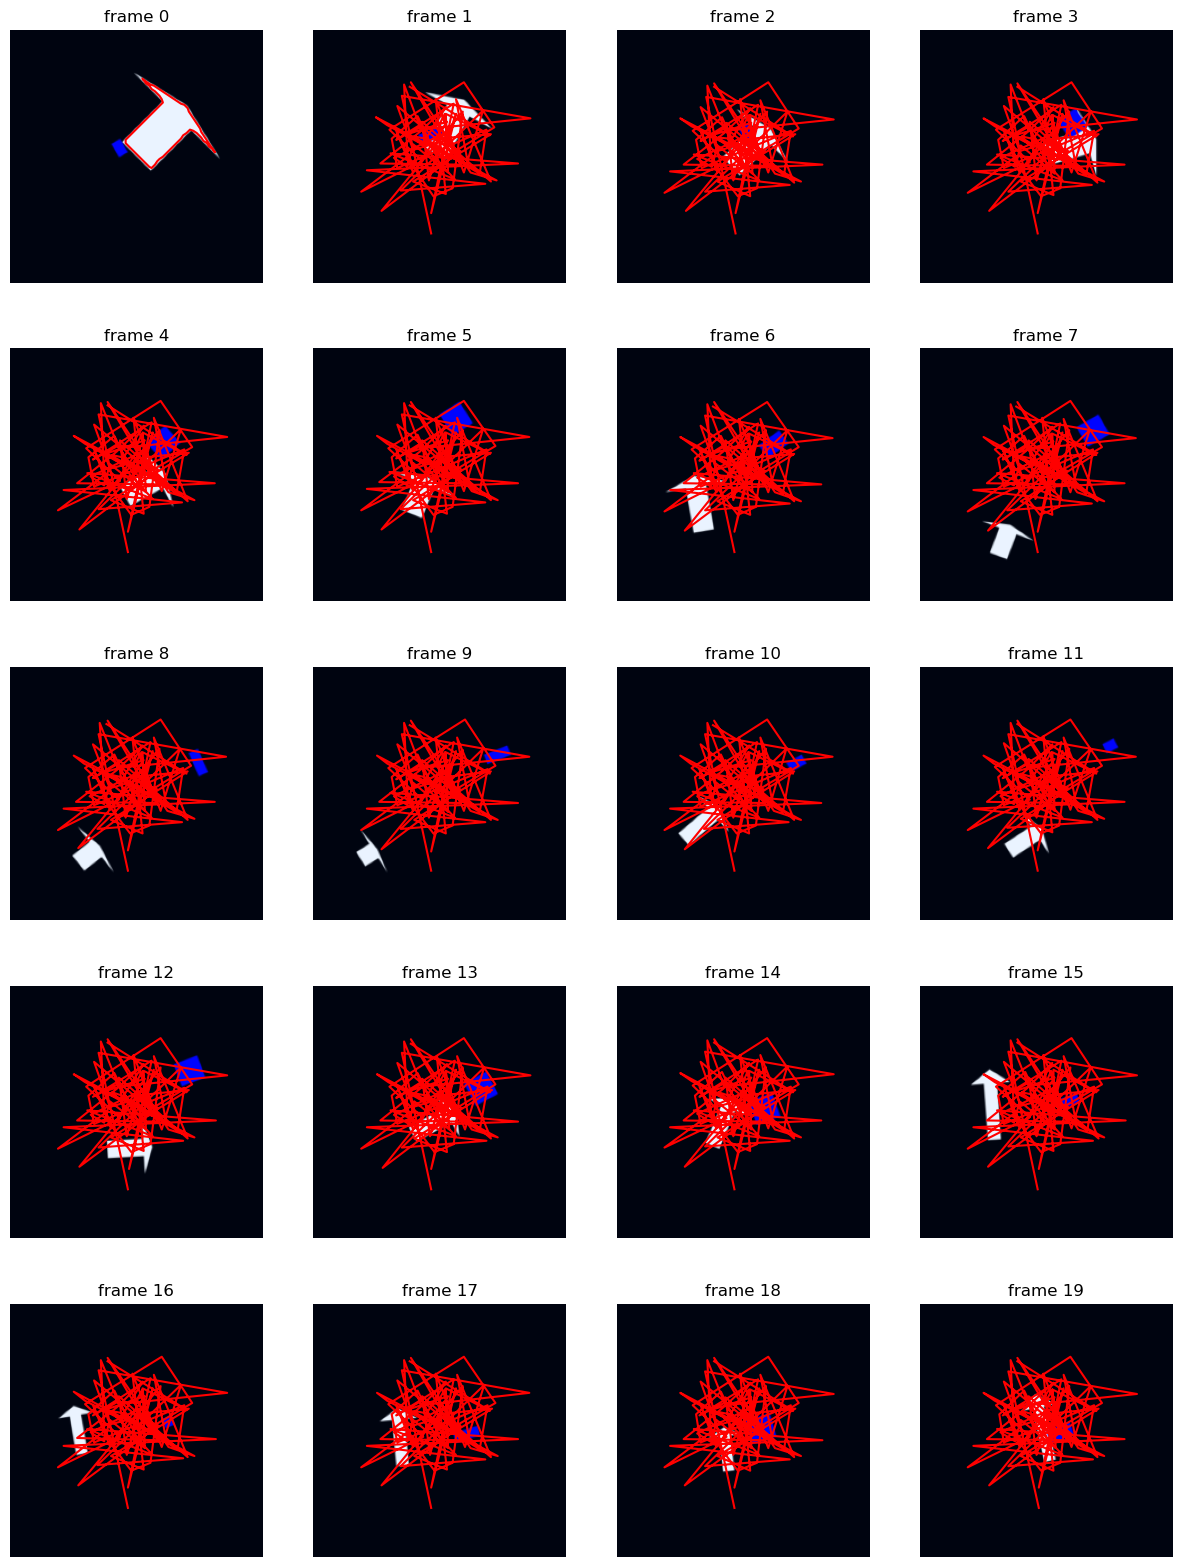

In [7]:
model_infer.show_infer_result(1, 0)

In [8]:
model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
).shape

torch.Size([1, 80, 2])

In [9]:
model = ResDetr().cuda()
ras_loss = RasLoss()
model_infer = TenVideoInfer(raw_set, is_detr=True)

/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not

In [10]:
loss_dict = {}
iou_dict = {}
interval_epochs = 50
inter_num = 42
epoch_index = 0
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [11]:
for interval in range(inter_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for (
            video_idx,
            pre_idx,
            fir_img,
            fir_bou,
            fir_sgm,
            pre_img,
            pre_bou,
            pre_sgm,
            cur_img,
            cur_bou,
            cur_sgm,
        ) in data_loader:
            optimizer.zero_grad()
            pred_bou = model(
                fir_img.cuda(),
                fir_sgm.cuda(),
                pre_img.cuda(),
                pre_sgm.cuda(),
                cur_img.cuda(),
            )
            loss = ras_loss(pred_bou, cur_sgm.cuda())
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        loss_dict[epoch_index] = mean_loss
        print(f"Epoch {epoch_index} Loss: {mean_loss}")
        epoch_index += 1
    model_infer.infer_model(model, 0)
    total_iou = model_infer.get_total_iou()
    iou_dict[epoch_index] = total_iou
    print(f"Epoch {epoch_index} IOU: {total_iou}")
    model_infer.show_infer_result(0, 0)
    break
    if interval_epochs > 50:
        interval_epochs = 50
    if interval_epochs > 20:
        interval_epochs -= 10
            
            

Epoch 0 Loss: 0.98933191644518
Epoch 1 Loss: 0.9904257413588072
Epoch 2 Loss: 0.990425591719778
Epoch 3 Loss: 0.9904255845044788
Epoch 4 Loss: 0.9904255440360621
Epoch 5 Loss: 0.9904255863867308
Epoch 6 Loss: 0.9904254022397493


KeyboardInterrupt: 

In [12]:
model_infer.show_infer_result(3, 0)

KeyError: 3

<Figure size 1500x2000 with 0 Axes>